# SONIC model - validation of NEURON implementation for "point" simulations

## NEURON implementation

### MOD file
Each neuron-specific MOD file contains several blocks:
- **NEURON** block: defines intrinsic currents as "non-specific" (to avoid dealing with ion concentrations) and declares RANGE variables that must be accessible 
- **PARAMETER** block: sets membrane properties (conductances and reversal potentials), and sets 2 parameters: $stimon$ (controlling the stimulation state) and $A_{drive}$ (acoustic amplitude)
- **STATE** block: declares differential variables other than $v$, i.e. ion channel gating states (and possibly intermediate regulating factors)
- **ASSIGNED** block: declares variable to track during simulation: $v$, $V_{m, eff}$ and ionic currents other evolving variables
- a set of **FUNCTION_TABLE**s to perform 2D interpolation of $V_{m, eff}$ and rate constants in the (amplitude x charge)  space
- **INITIAL** block: defines initial values of states
- **BREAKPOINT** block: main computational block, solving states and computing currents
- **DERIVATIVE** block: defines differential equations for states

### Python caller
Model instantiation:
- Load mechanisms DLL file
- Create a single morphological section
- Load neuron-specific membrane mechanism and insert it into the section
- Load appropriate (amplitude x charge) interpolation tables and link them to **FUNCTION_TABLE**s in the corresponding membrane mechanism

Model simulation:
- Define stimulation parameters (amplitude, duration, PRF, duty cycle)
- Set probe vectors to record the evolution of $t$, $Q_m$, $V_{m,eff}$ and other variables
- Set CVODE events to turn stimulation ON and OFF at pulse onsets and offsets, respectively
- Initialize and integrate the model
- Retrieve output variables in Python

## Similarities and differences

| feature                                          | Python                                 |  Python+NEURON              |
|:------------------------------------------------:|:--------------------------------------:|:---------------------------:|
| ODE solver                                       | **LSODA (Adams method)**               | **Crank-Nicholson (cnexp)** |
| Time step                                        | **Fixed (0.05 ms)**                    | **Adaptive (atol = 0.001)** |
| Integration of US-ON periods                     | Interpolation tables                   | Interpolation tables        |
| Integration of US-OFF periods                    | Interpolation tables                   | Interpolation tables        |

## Validation 

### Imports
Let's import the necessary packages and modules.

In [1]:
import logging
import numpy as np

from PySONIC.utils import logger, si_format
from PySONIC.neurons import *
from ExSONIC.test import TestNodePythonVsNeuron

logger.setLevel(logging.INFO)
tester = TestNodePythonVsNeuron()

### Parameters
Let's set some default model and stimulation parameters.

In [3]:
# Model parameters
pneuron = CorticalRS()
a = 32e-9  # sonophore diameter (m)

# Stimulation parameters
Fdrive = 500e3  # Hz
Adrive = 50e3  # Pa
tstim = 150e-3  # s
toffset = 100e-3  # s
PRF = 100.  # Hz
DC = 1.

### Different neuron types in default conditions

 19/08/2019 12:02:03: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:02:03: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
C:\Users\lemaire\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
 19/08/2019 12:02:08: SonicNode(32.0 nm, CorticalFS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:02:08: NeuronalBilayerSonophore(32.0 nm, CorticalFS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:02:15: SonicNode(32.0 nm, CorticalLTS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:02:15: NeuronalBilayerSonophore(32.0 nm, CorticalLTS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 15

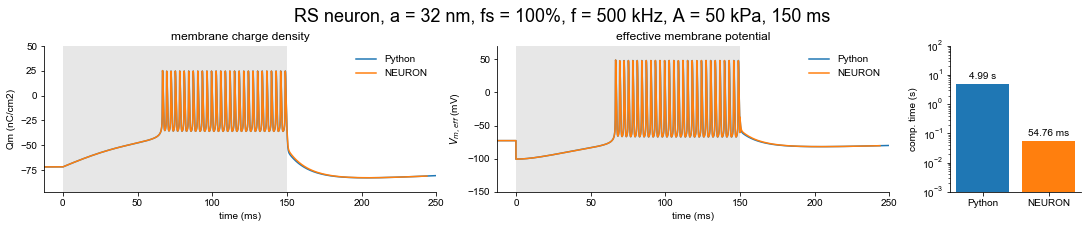

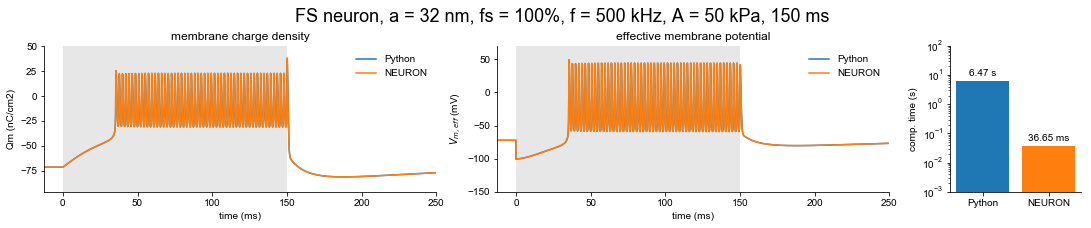

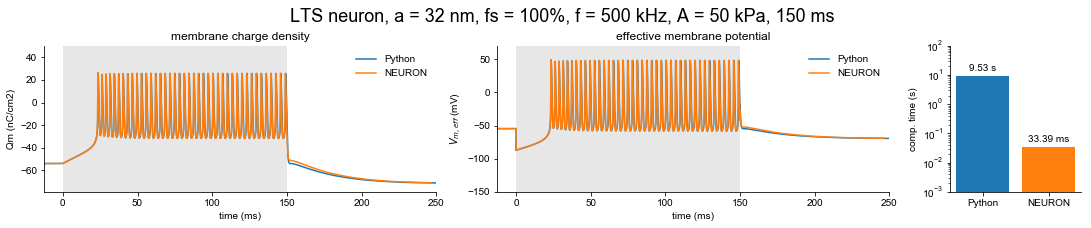

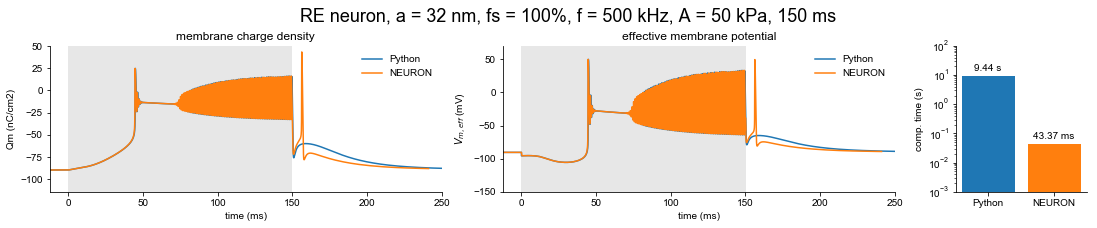

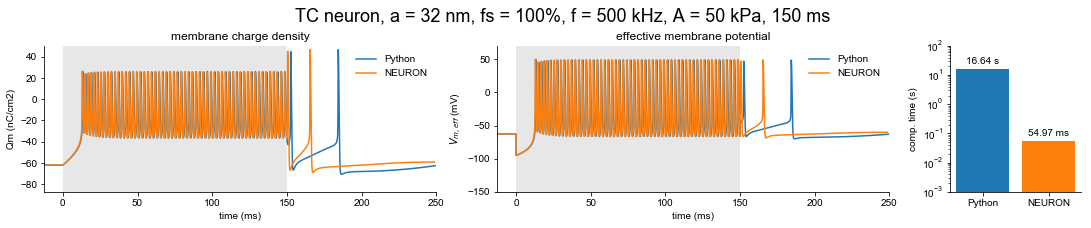

In [7]:
for neuron_str in ['RS', 'FS', 'LTS', 'RE', 'TC']:
    fig = tester.compare(getNeuronsDict()[neuron_str](), Adrive, tstim, toffset, PRF=PRF, DC=DC, a=a, Fdrive=Fdrive)

We notice, for the 5 neuron types:
- Identical build-up rates
- Identical spike trains during the stimulus
- Similar post-offset behaviors with small differences in spike timing due to sensitivity to offset resolution
- Stabilization around identical steady-state

Hence, the NEURON implementation accurately captures neuron-specific responses to a typical CW stimulus.

Moreover, it's about 2 orders of magnitude faster than the pure Python implementation.

### Influence of sonophore diameter

 19/08/2019 12:03:01: SonicNode(16.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:01: NeuronalBilayerSonophore(16.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:01: SonicNode(25.4 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:01: NeuronalBilayerSonophore(25.4 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:04: SonicNode(40.3 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:04: NeuronalBilayerSonophore(40.3 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:12: SonicNode(64.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:12: NeuronalBilayerSonophore(64.0 nm, CorticalRS): simulati

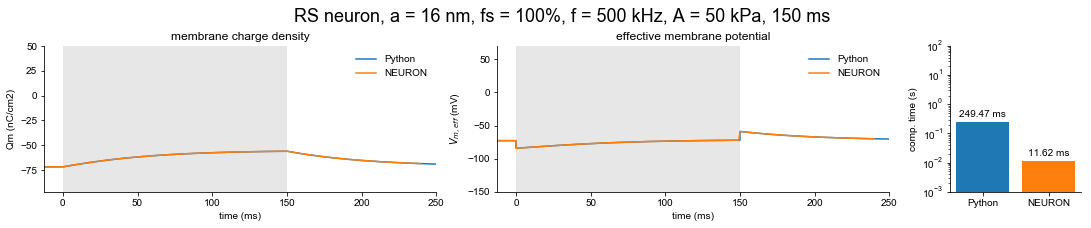

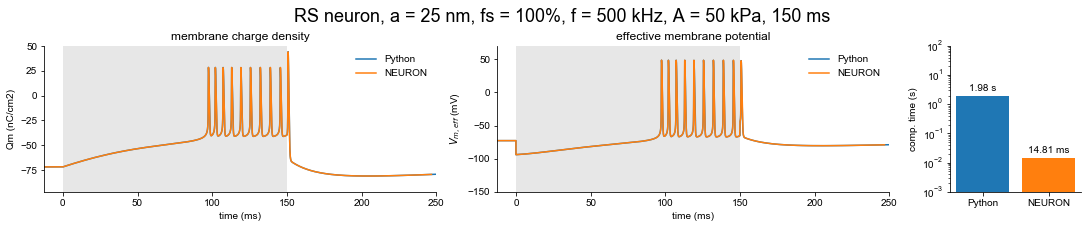

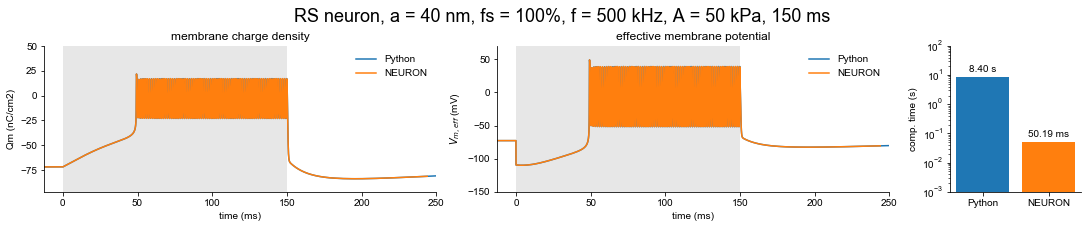

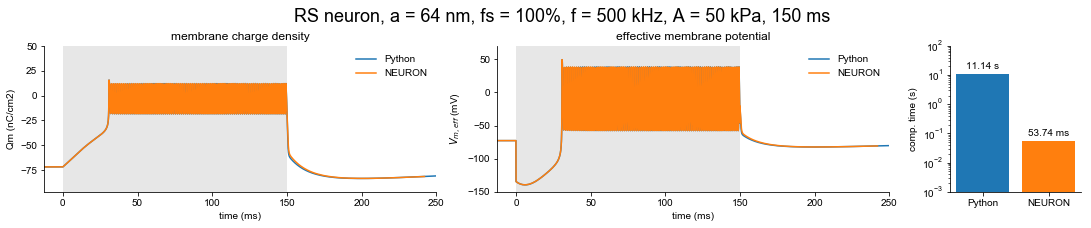

In [8]:
for a_range in np.logspace(np.log10(16.0), np.log10(64.0), 4) * 1e-9:
    fig = tester.compare(pneuron, Adrive, tstim, toffset, PRF, DC, a=a_range, Fdrive=Fdrive)

As the sonophore diameter increases (from 16 to 64 nm), both solutions transition from a passive response to continous spike train with similar changes in spike shape (progressive reduction of spike amplitude)

### Sensitivity to stimulus frequency

 19/08/2019 12:03:33: SonicNode(32.0 nm, CorticalRS, 20 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:33: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 20 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:38: Rounding f value (4000000.000000001) to interval upper bound (4000000.0)
 19/08/2019 12:03:38: Rounding f value (4000000.000000001) to interval upper bound (4000000.0)
 19/08/2019 12:03:38: SonicNode(32.0 nm, CorticalRS, 4000 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:38: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 4 MHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:38: Rounding f value (4000000.000000001) to interval upper bound (4000000.0)


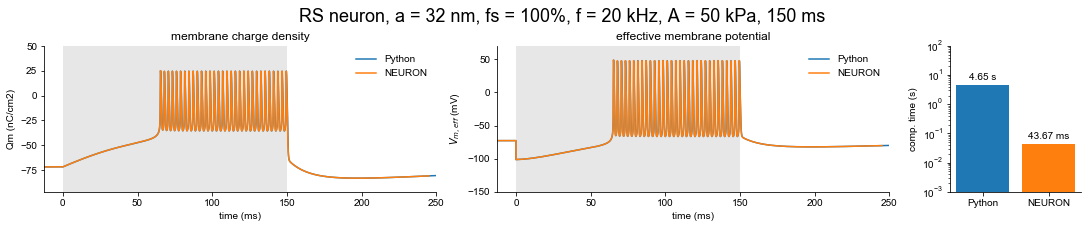

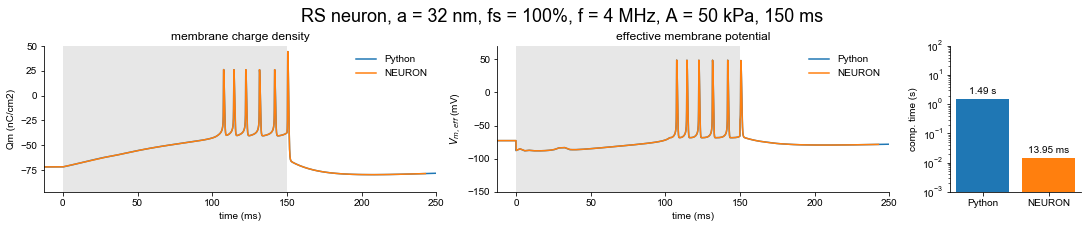

In [10]:
for Fdrive_range in np.logspace(np.log10(20), np.log10(4e3), 2) * 1e3:
    fig = tester.compare(pneuron, Adrive, tstim, toffset, PRF, DC, a=a, Fdrive=Fdrive_range)

We observe identical changes in spike shapes when varying US frequency within the range of lookups definitions (20 kHz - 4 MHz).

### Sensitivity to stimulus amplitude

 19/08/2019 12:03:52: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 37.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:52: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 37.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:53: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 149.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:03:53: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 149.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:04:02: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 600.00 kPa, t = 150.0 ms (100.0 ms offset)
 19/08/2019 12:04:02: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 600.00 kPa, t = 150.0 ms (100.0 ms offset)


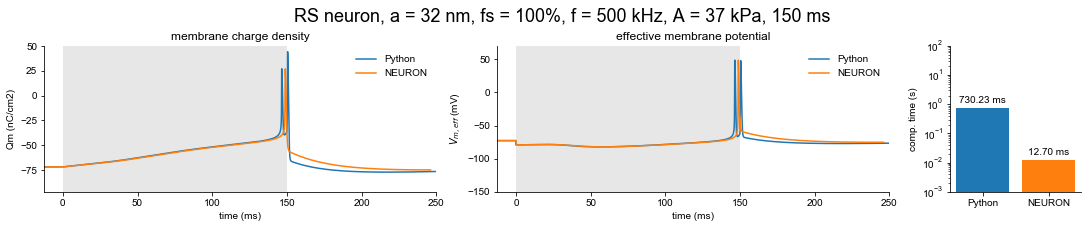

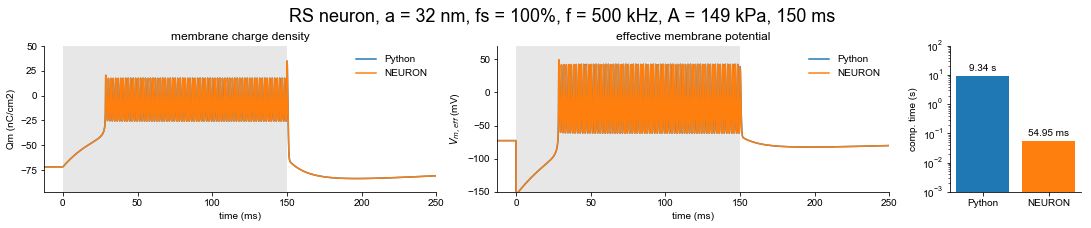

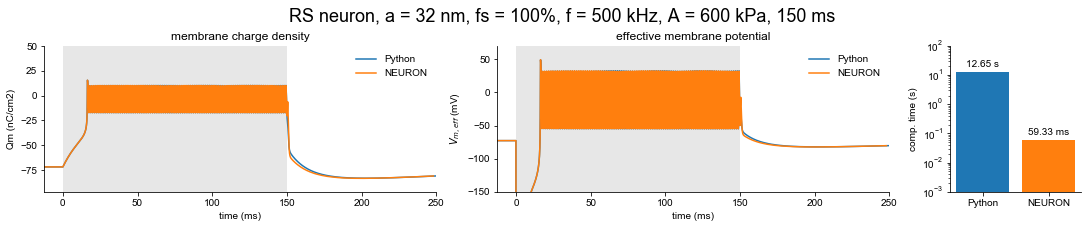

In [11]:
for Adrive_range in np.logspace(np.log10(37), np.log10(600), 3) * 1e3:
    fig = tester.compare(pneuron, Adrive_range, tstim, toffset, PRF, DC, a=a, Fdrive=Fdrive)

We observe identical changes in spike shapes when varying acoustic amplitude from the excitation threshold to the upper bound of lookups definitions (40 - 600 kPa).

### Sensitivity to duty cycle

 19/08/2019 12:04:37: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 70.00%
 19/08/2019 12:04:37: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 70.00%
 19/08/2019 12:04:39: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:04:39: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%


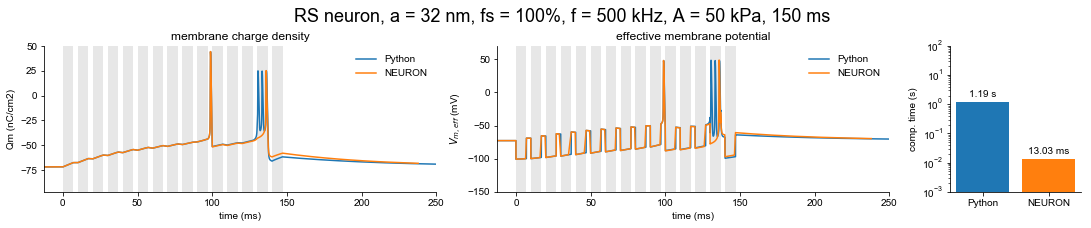

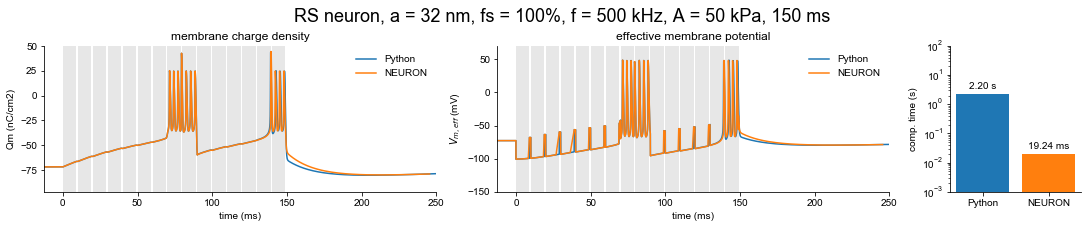

In [12]:
for DC_range in np.linspace(0.7, 0.9, 2):
    fig = tester.compare(pneuron, Adrive, tstim, toffset, PRF, DC_range, a=a, Fdrive=Fdrive)

We observe a few differences between the two solutions:

- during the build-up phase, the smooth system evolution allows NEURON's CVODE solver to use a larger time step, yielding a lower temporal resolution (seen on the $V_{m,eff}$ graphs). However, thanks to the use of CVODE events, the CVODE integrator is forced to return and re-initialize precisely at ON/OFF transitions, hence the system evolution is still accurately computed.
- as the spiking threshold is reached, NEURON's CVODE solver reduces the time step to adapt to the faster system evolution, hence spikes are properly integrated.
- a very small divergence emerges after 1 or several spike bursts, due to the tremendous sensitivity of the system to pulse-spike relative timing. This divergence is then propagated to subsequent bursts but stays reasonable and does not significantly alter the neuron's spiking metrics. 

### Increasing accuracy

We can try to increase results accuracy by setting a more stringent absolute error tolerance $a_{tol}$:

 19/08/2019 12:05:05: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:05:05: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:05:07: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:05:07: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:05:10: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:05:10: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%


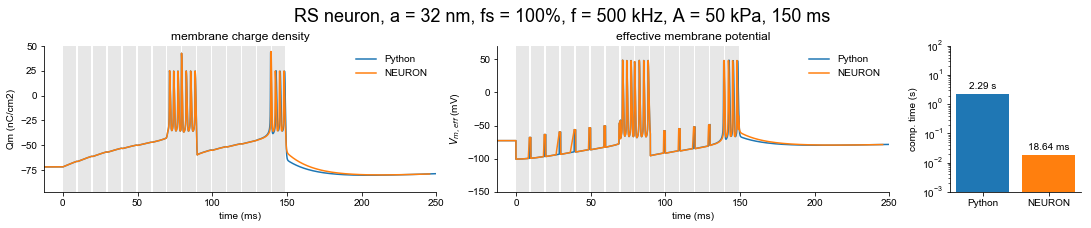

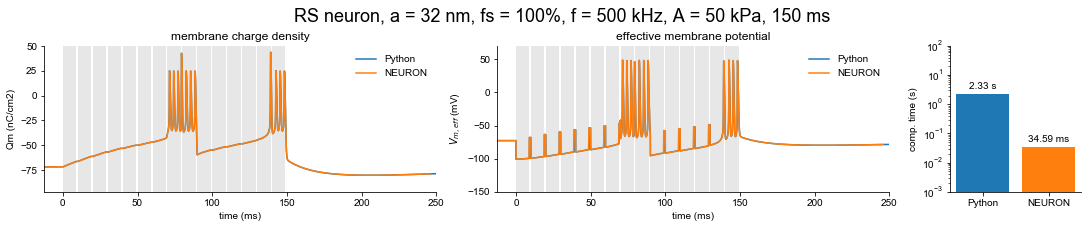

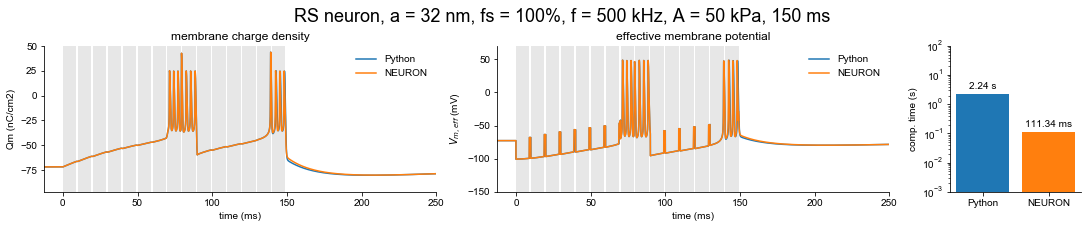

In [14]:
for atol in np.logspace(-3, -7, 3):
    fig = tester.compare(pneuron, Adrive, tstim, toffset, PRF, 0.9, a=a, Fdrive=Fdrive, atol=atol)

Divergence is eliminated if we reduce $a_{tol}$ by 2 orders of magnitude (below to $10^{-5}$)., whtout a significant increase in computation time.

We can also try to increase results accuracy by forcing a small, fixed integration time step:

 19/08/2019 12:07:16: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:07:16: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
C:\Users\lemaire\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
 19/08/2019 12:07:19: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:07:19: NeuronalBilayerSonophore(32.0 nm, CorticalRS): simulation @ f = 500 kHz, A = 50.00 kPa, t = 150.0 ms (100.0 ms offset), PRF = 100.00 Hz, DC = 90.00%
 19/08/2019 12:07:21: SonicNode(32.0 nm, CorticalRS, 500 kHz): simulation @ A_US = 50.00 kPa, t = 150.0 ms (100.0 ms offset

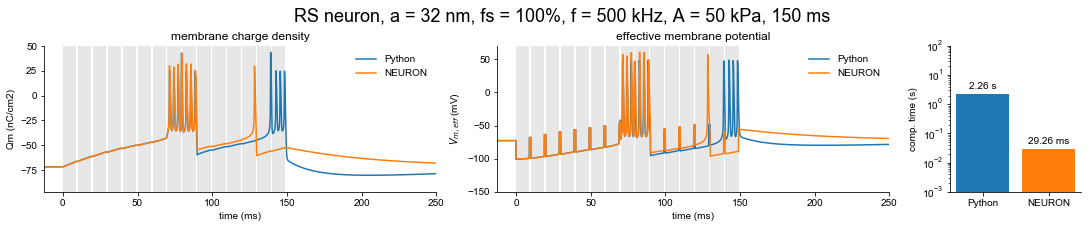

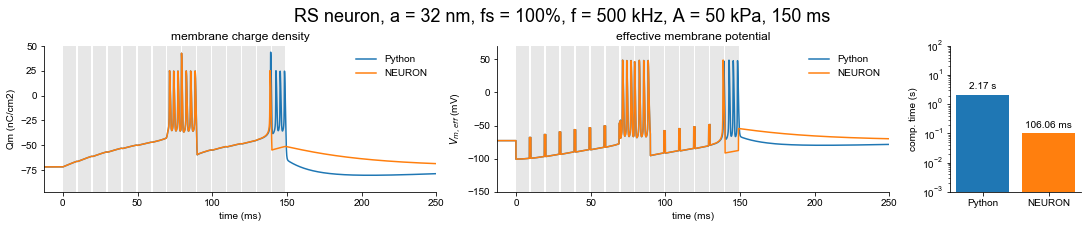

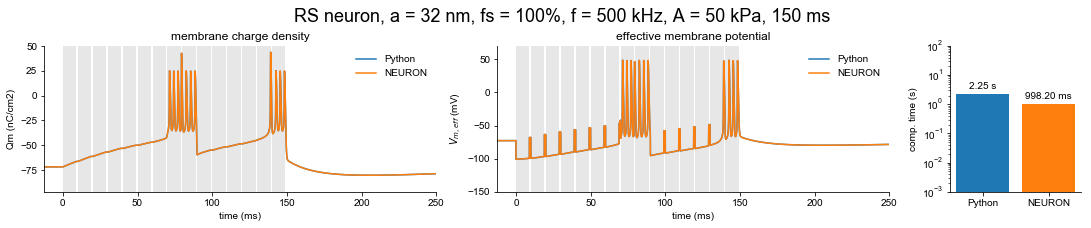

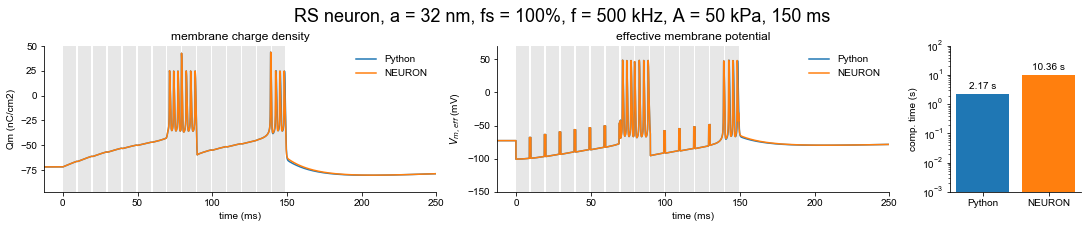

In [4]:
for dt in np.logspace(-4, -7, 4):
    fig = tester.compare(pneuron, Adrive, tstim, toffset, PRF, 0.9, a=a, Fdrive=Fdrive, dt=dt)

Divergence is also eliminated for time step below $1\ \mu s$. (1e-6 s), however this implies a **drastic (> 10-fold) decrease in computational efficiency.**.

Hence, the adaptive time step method seems to provide a better compromise between speed and accuracy.

## Conclusions

- **NEURON implementation can perform accurate simulations of point-neuron SONIC model**, across different cell types and parameter combinations
- Small divergences can arise for PW stimuli with many ON/OFF transitions, however these divergences can be eliminated by imposing more stringent integration conditions.
- **NEURON's adaptive integration method looks to be the most suited** for this kind of problem, as it sets a good compromise between accuracy and computational efficiency.
- On average, **NEURON simulations with the adaptive time step method are about 2 orders of magnitude faster than pure-Python simulations**